# Домашнее задание №2. Multi-class SVM.

Нужно реализовать несколько алгоритмов SVM с помощью numpy/scipy библиотек. Каждую из реализаций сравнить с соответсвующей sklearn реализацией SVM алгоритма.

## Задание №1 (15 баллов)

Реализовать класс **LinearPrimalSVM** - метод решения **много-классового линейного метода опорных векторов в стандартной задаче  оптимизации с квадратичной регуляризацией**. Для обучения много-классового алгоритма воспользоваться схемой **one-vs-rest**.  Реализовать методы init, fit, predict c возможностью конфигурации параметра регуляризации. Остальные функции реализовать на ваше усмотрение.

Для оптимизации функции ошибки воспользоваться методом **стохастического градиентного спуска**.

In [ ]:
import numpy as np
from sklearn.datasets import load_wine, load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy import optimize

In [ ]:
class LinearPrimalSVM:
    def __init__(self, regularization_type, C=1, learning_rate=1e-4, alpha=0.0001, max_iter=1000, n_samples=10, tol=1e-3):
        self.regularization_type = regularization_type
        self.C = C
        self.theta = 0
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.n_samples = n_samples
        self.tol = tol

    def transofrm_y(self, y):
        '''
        Трансформируем таргеты
        '''
        pass

    def hinge_loss(self, X, y, theta):
        '''
        Целевая функция стандартной задачи оптимизации
        '''
        L = 0
        for i in range(X.shape[0]):
            L += np.maximum(0, 1 - y[i] * (np.dot(theta[:-1], X[i,:]) - theta[-1]))

        if self.regularization_type == 'l1':
            return self.alpha * 1/2 * np.sum(np.square(theta[:-1])) ** 2 + self.C * L
        else:
            return 1/2 * self.alpha * np.sum(np.square(theta[:-1])) ** 2 + self.C * L

    def grad_hinge_loss(self, X, y, theta):
        '''
        Вычисляем субградиент функции (так как градиента в 0 не существует)
        '''
        grad = 0
        for i in range(X.shape[0]):
            grad += self.C * -(y[i] * X[i,:]) * (1 - y[i] * (np.dot(theta[:-1], X[i,:]) - theta[-1]) > 0)
        if self.regularization_type == 'l1':
            return np.concatenate((grad + self.alpha * np.sign(theta[:-1]), self.C * theta[-1:]* np.sum(y)))
            #return grad + self.alpha * np.sign(theta[:-1])
        else:
            return np.concatenate((grad + 2 * self.alpha * theta[:-1], self.C * theta[-1:] * np.sum(y)))
            #return grad + 2 * self.alpha * theta[:-1]

    def fit(self, X, y):
        """функция обучения модели"""
        labels = len(set(y))
        self.theta = np.zeros((labels, X.shape[1] + 1))
        for label in range(labels):
            y_transformed = np.where(y == label, 1, -1)
            loss = self.hinge_loss(X, y_transformed, self.theta[label,:])
            k = 0
            while k < self.max_iter:
                k += 1
                random_ind = np.random.choice(X.shape[0], self.n_samples, replace=True)
                X1 = X[random_ind]
                y_transformed1 = y_transformed[random_ind]
                avg_grad = 1/self.n_samples * self.grad_hinge_loss(X1, y_transformed1, self.theta[label,:])
                self.theta[label,:] = self.theta[label,:] - self.learning_rate * avg_grad
                #if self.hinge_loss(X1,y_transformed1,self.theta[label,:]) < loss - self.tol:
                 # loss = self.hinge_loss(X1,y_transformed1,self.theta[label,:])
                #else:
                 # break



    def predict(self, X):
        """функция предсказания"""
        scores = np.dot(X, self.theta[:,:-1].T) + self.theta[:,-1].T
        predictions = np.argmax(scores, axis=1)
        return predictions

    def score(self, X, y):
        y1 = np.array(y)
        N = X.shape[0]
        # Находим количество элементов, в которых массивы различаются
        count_different = np.count_nonzero(y1 == self.predict(X))
        return count_different/N

Оцените ваш алгоритм на тестовом сплите многоклассовом датасете классификации по выбранной метрике качества. Датасеты для классификации можно взять например [**отсюда**](https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table) или сгенерировать самому. Сравните ваш алгоритм с sklearn имплементацией со следующими парарметрами:

[*_sklearn.linear_model.SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True)_*](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)

Остальные параметры алгоритма на ваше усмотрение.

Отличие в качестве не должно составлять более **1-2%** в пользу sklearn имплементации. Ваш алгоритм может работать лучше.

In [ ]:
X, y = load_iris(return_X_y=True, as_frame=True)

In [ ]:
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((105, 4), (45, 4))

In [ ]:
ss = StandardScaler().fit(X)

X_norm = ss.transform(X)
X_train_norm = ss.transform(X_train)
X_test_norm = ss.transform(X_test)

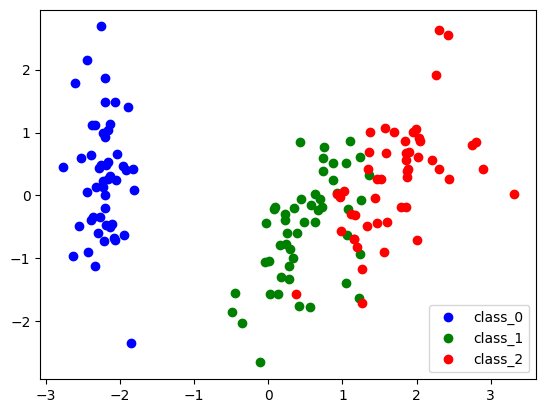

In [ ]:
# Прогоним встроенный в sklearn PCA
pca = PCA(n_components=2)
pca.fit(X_norm)
X_pca = pca.transform(X_norm)

# И нарисуем получившиеся точки в нашем новом пространстве
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='class_0')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='class_1')
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='class_2')
plt.legend(loc=0);

In [ ]:
clf = SGDClassifier(loss='hinge', penalty='l2', fit_intercept=True, verbose=0, learning_rate='constant', eta0=1e-2, average=10)
clf.fit(X_train_norm, y_train)

SGDClassifier(average=10, eta0=0.01, learning_rate='constant')

In [ ]:
clf.score(X_test_norm, y_test)

0.8

In [ ]:
svm = LinearPrimalSVM(regularization_type='l2', max_iter=1000, n_samples = 10, learning_rate=1e-2)

In [ ]:
svm.fit(X_train_norm, y_train)

In [ ]:
svm.score(X_test_norm, y_test)

0.8444444444444444

В моей реализации fit'a присуствует доля рандома, в редких случаях выдает значение похуже чем 1-2%

### Задание № 2 (10 баллов)

Визуализируйте построенные разделяющие прямые на вашем мультиклассовом датасете. Для визуализации можно пользоваться любыми библиотеками визуализации. В конце ноутбука приведены вспомогательные функции для визуализации.

In [ ]:
from sklearn import datasets
wine = datasets.load_iris()

<ipython-input-14-bea4dee635a9>:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


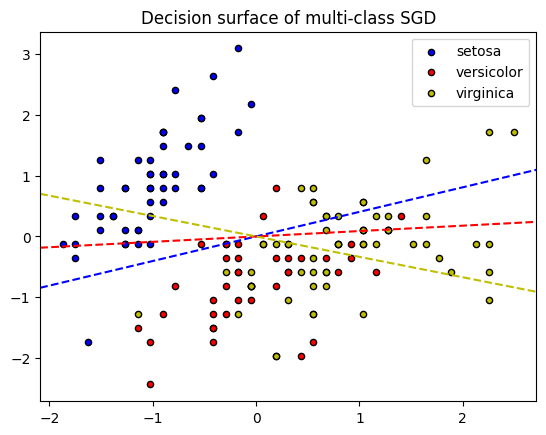

In [ ]:
#уменьшим размерность данных до 2
a, b = X_norm[:, 0:2], y

colors = 'bry'
classes = np.array([0,1,2])

#визуализируем данные
for i,color in zip(classes, colors):
  idx = np.where(b == i)
  plt.scatter(
        a[idx, 0],
        a[idx, 1],
        c=color,
        label=wine.target_names[i],
        cmap=plt.cm.Paired,
        edgecolor="black",
        s=20,
    )
plt.title("Decision surface of multi-class SGD")
plt.axis("tight")

#Построим разделяющие гиперплоскости
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()



def plot_hyperplane(c, color):
    def line(x0):
        return (-(x0 * svm.theta[c, 0]) - svm.theta[c,-1:]) / svm.theta[c, 1]

    plt.plot([xmin, xmax], [line(xmin), line(xmax)], ls="--", color=color)

for i, color in zip(classes, colors):
    plot_hyperplane(i, color)
plt.legend()
plt.show()

Постройте график зависимости качества вашего алгоритма от параметра регуляризации на тестовом сплите.

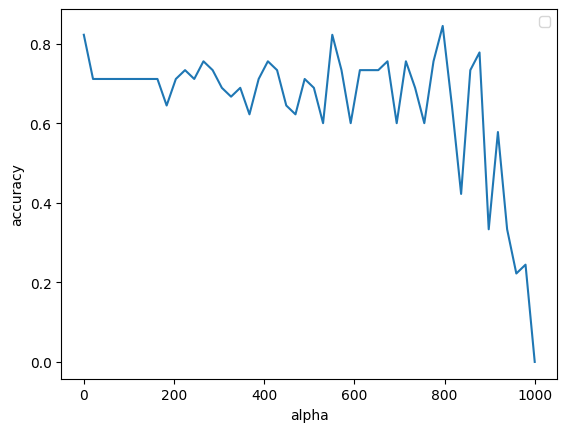

In [ ]:
alphas = np.linspace(1e-3, 1e3, num=50)

acc = []
for alpha in alphas:
  m = LinearPrimalSVM(regularization_type='l2', alpha=alpha, learning_rate=1e-2)
  m.fit(X_train_norm, y_train)
  acc.append(m.score(X_test_norm, y_test))

plt.plot(alphas,acc)
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.legend()
plt.show()


### Задание №3 (10 баллов)

Реализовать **NonlinearDualSVM** - метод решения **много-классового нелинейного метода опорных векторов двойственной задаче  оптимизации с квадратичной регуляризацией с поддежкой любого нелинейного ядра**. Алгоритм решения SVM через двойственную задачу можно взять из ноутбука, который мы рассматривали в классе - вам нужно поддержать многоклассовое решение задачи и поддержку ядра для решений в нелинейном случае.

Для обучения много-классового алгоритма воспользоваться схемой **one-vs-one**. В качестве нелинейного ядра можно взять любое нелинейное [отсюда](https://scikit-learn.org/stable/modules/svm.html#svm-kernels).

**Подсказка**

Получить получить ядерную матрицу Грамма можно так:

```python
# X shape is (N, dim)
# y_hat shape is (N, 1)

def kernel(x1, x2):
    return np.dot(x1, x2)

kernalized_X = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2: kernel(x1, x2), 1, X), 1, X)  
gram_matrix_Xy = kernalized_X * np.matmul(y_hat, y_hat.T)
```

In [ ]:
def langrange(gramm_matrix, alpha):
    """двойственная функция"""
    return alpha.sum() - 0.5 * np.dot(alpha, np.dot(alpha, gramm_matrix))

def langrange_derive(gramm_matrix, alpha):
    """производная двойственной функции по alpha"""
    return np.ones(alpha.shape) - np.dot(alpha, gramm_matrix)

In [ ]:
class SoftMarginSVM:

    def __init__(self, C, kernel):
        # Добавим параметр регуляризации/параметр влияния на ошибку
        self.C = C
        self.kernel = kernel
        self.alpha = None
        self.w = None
        self.supportVectors = None

    def fit(self, X, y):
        N = len(y)
        X1 = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2: self.kernel(x1, x2), 1, X), 1, X)
        X1y = X1 * y.reshape(-1,1 )
        GramXy = np.matmul(X1y, X1y.T)
        Xy = X * y.reshape(-1,1)
        #зададим ограничения для SoftMarginSVM
        #(alpha, y) = 0
        first_constraint = {'type': 'eq',   'fun': lambda a: np.dot(a, y), 'jac': lambda a: y}
        #(0 <= alpha <= C)
        A = np.vstack((-np.eye(N), np.eye(N)))
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))
        second_constraint = {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A}
        constraints = (first_constraint, second_constraint)

        opt_res = optimize.minimize(fun=lambda a: -langrange(GramXy, a),
                                   x0=np.ones(N),
                                   method='SLSQP',
                                   jac=lambda a: -langrange_derive(GramXy, a),
                                   constraints=constraints)
        self.alpha = opt_res.x
        #self.w = np.sum((self.alpha.reshape(-1,1) * Xy), axis=0)
        epsilon = 1e-6
        self.supportVectors = X[self.alpha > epsilon]
        self.supportLabels = y[self.alpha > epsilon]
        self.alpha = self.alpha[self.alpha > epsilon]

        self.b = np.mean(self.supportLabels - np.sum(self.kernel(self.supportVectors, self.supportVectors) *
                                                       self.alpha * self.supportLabels, axis=1))


    def predict(self, X):
        """ Predict y value in {-1, 1} """
        #def nonlin_clf(x):
        #  return self.kernel(x,self.w) + b
        #p = np.array([None for i in range(X.shape[0])])
        #for i in range(X.shape[0]):
        #  p[i] = 2 * (self.kernel(X[i],self.w) + self.b > 0) - 1
        #return p
        p = np.sum(self.kernel(X, self.supportVectors) * self.alpha * self.supportLabels, axis=1) + self.b
        return np.sign(p)

In [ ]:
class NonlinearDualSVM:
    def __init__(self, regularization_type='l2', ker='rbf', C=1.0, degree=3, gamma='scale', coef0=0.0):
        self.regularization_type = regularization_type
        self.C = C #параметр регуляризации
        self.ker = ker #тип ядра
        self.degree = degree #степень полиномиального ядра
        self.gamma = gamma #коэффициент ядра
        self.coef0= coef0
        self.alpha = None
        self.w = None
        self.supportVectors = None
        self.b = None

    def kernel(self, x1, x2):
      ''' Kernel functions '''
      if self.ker == 'poly':
        return (self.gamma * np.dot(x1, x2.T) + self.coef0) ** self.degree
      elif self.ker == 'rbf':
        return np.exp(-self.gamma * np.linalg.norm(x1-x2)**2)
      else:
        return np.tanh(self.gamma * np.dot(x1,x2.T) + self.coef0)

    def fit(self, X, y):
        """функция обучения модели"""
        self.labels = len(set(y))
        if self.gamma == 'scale':
          self.gamma = 1/(X.shape[1] * np.var(X))
        if self.gamma == 'auto':
          self.gamma = 1/X.shape[1]
        self.alpha = [self.labels * [0] for i in range(self.labels)]
        self.w = [self.labels * [0] for i in range(self.labels)]
        self.b = np.array([self.labels * [0] for i in range(self.labels)])
        self.models = [[0 for i in range(j)] for j in range(self.labels)]
        y = np.array(y)
        for label1 in range(self.labels):
          for label2 in range(label1):
            if label1 == label2:
              continue
            idx1 = list(np.where(y == label1)[0])
            idx2 = list(np.where(y == label2)[0])
            idx = np.array(idx1 + idx2)
            y_transformed = y[idx]
            y_transformed = np.where(y_transformed == label1, 1, -1)
            X1 = X[idx]
            #gram_matrix_Xy = kernalized_X * np.matmul(y_transformed, y_transformed.T)
            model = SoftMarginSVM(self.C, self.kernel)
            model.fit(X1, y_transformed)
            self.models[label1][label2] = model

    def predict(self, X):
        """функция предсказания"""
        predictions = np.zeros((self.labels, X.shape[0]))
        targets = np.array([i for i in range(self.labels)])
        for i in range(self.labels):
          for j in range(i):
            prediction = self.models[i][j].predict(X)
            predictions[i] += (prediction == 1)
            predictions[j] += (prediction == -1)
        return targets[np.argmax(predictions, axis=0)]

    def score(self, X, y):
        y1 = np.array(y)
        N = X.shape[0]
        # Находим количество элементов, в которых массивы различаются
        return np.mean(self.predict(X) == y1)

Оцените ваш алгоритм на тестовом сплите многоклассовом датасете классификации по выбранной метрике качества. Датасеты для классификации можно взять например [**отсюда**](https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table) или сгенерировать самому. Сравните ваш алгоритм с sklearn имплементацией со следующими параметрами:

[*_class sklearn.svm.SVC(kernel='poly/rbf/sigmoid')_*](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

Остальные параметры алгоритма на ваше усмотрение либо при необходимости для выбранного ядра.

Ваш алгоритмом должен быть не хуже sklearn имплементации алгоритма (допустима разница **5%** в пользу sklearn). Ваш алгоритм может работать лучше.

In [ ]:
from sklearn.svm import SVC

In [ ]:
nonlinsvm = NonlinearDualSVM(ker='sigmoid', gamma='scale', degree=2)
nonlinsvm.fit(X_train_norm, y_train)
nonlinsvm.score(X_test_norm, y_test)

0.8222222222222222

In [ ]:
svc = SVC(kernel='sigmoid', gamma='scale', degree=2)
svc.fit(X_train_norm, y_train)
svc.score(X_test_norm, y_test)

0.8666666666666667

#### Вспомогательные функции визуализации

Для удобства визуализации используйте эти функции.

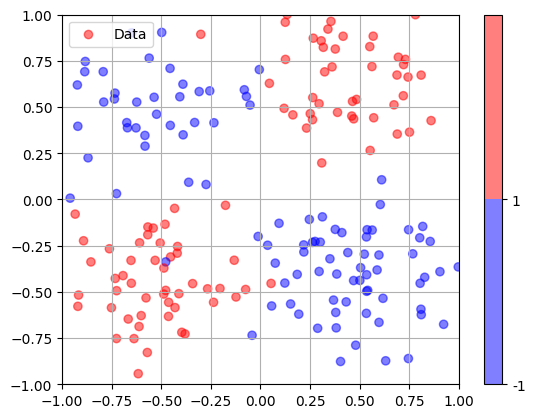

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import numpy as np

def plot_line(ax, x_range, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """График разделяющей прямой с помощью вектора весов w и смещения x0"""
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (x_range - x0[0]) + x0[1]
    ax.plot(x_range, yy, color=color, label=label, linestyle=linestyle)

def plot_svm(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Separator',
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """График SVM оптимальной разделяющей прямой c отображением опорных векторов support
    вектора весов w и смещения intercept"""
    if ax is None:
        fig, ax = plt.subplots(1)

    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=80, facecolors='none',
                   edgecolors='y', color='y')
        print("Количество опорных векторов = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plot_line(ax, xx, w, intercept, separatorLabel)
        # Plot margin
        if support is not None:
            signed_dist = np.matmul(support, w)
            margin = np.max(signed_dist) - np.min(signed_dist) * np.sqrt(np.dot(w, w))
            support_max_neg = support[np.argmin(signed_dist)]
            plot_line(ax, xx, w, support_max_neg, 'Margin -', linestyle='-.', alpha=0.8)
            support_max_pos = support[np.argmax(signed_dist)]
            plot_line(ax, xx, w, support_max_pos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])


def generate_batch_xor(n, mu=0.5, sigma=0.5):
    """ гауссианы в форме XOR операции"""
    X = np.random.normal(mu, sigma, (n, 2))
    yB0 = np.random.uniform(0, 1, n) > 0.5
    yB1 = np.random.uniform(0, 1, n) > 0.5
    # y is in {-1, 1}
    y0 = 2. * yB0 - 1
    y1 = 2. * yB1 - 1
    X[:,0] *= y0
    X[:,1] *= y1
    X -= X.mean(axis=0)
    return X, y0*y1

colors = ['blue','red']
cmap = pltcolors.ListedColormap(colors)
nFeatures = 2
N = 100
xTrain3, yTrain3 = generate_batch_xor(2*N, sigma=0.25)
plot_svm(xTrain3, yTrain3)
#xTest3, yTest3 = generate_batch_xor(2*N, sigma=0.25)